A point cloud is a collection of points in a three-dimensional coordinate system. Each point in a point cloud represents a tiny part of a larger surface or object. These points collectively form a shape that can be used for various applications such as 3D modeling, visualization, and analysis.

In this tutorial, a point cloud of the Pittsburgh Bridge is loaded and rendered. The rendering process is controlled through different components like cameras, rasterizers, and compositors, each affecting how the final image appears. Cameras, such as orthographic or perspective cameras, define the view and angle from which the point cloud is visualized. Rasterizers convert the 3D point cloud into a 2D representation, while compositors determine how points blend on the screen, with techniques like alpha compositing and weighted compositing being discussed.

# Installation

In [8]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [9]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

# Loading a Point Cloud
Pointclouds is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes.

In [10]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2025-04-24 11:59:29--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.50, 13.35.7.128, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘data/PittsburghBridge/pointcloud.npz.1’

pointcloud.npz.1    100%[===================>]   5.44M  18.5MB/s    in 0.3s    

2025-04-24 11:59:29 (18.5 MB/s) - ‘data/PittsburghBridge/pointcloud.npz.1’ saved [5701352/5701352]



A point cloud is a set of 3D coordinates (x, y, z) and often each point has color information (r, g, b). Each point represents a "dot" on the surface of an object, like a pixel but in 3D.
"verts" are just 3D positions of points, and nothing is connected

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)

rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

# Creating a renderer
A renderer in PyTorch3D is composed of a rasterizer and a shader which each have a number of subcomponents such as a camera (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a renderer which uses an orthographic camera, and applies alpha compositing. Then we learn how to vary different components using the modular API.

In [13]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

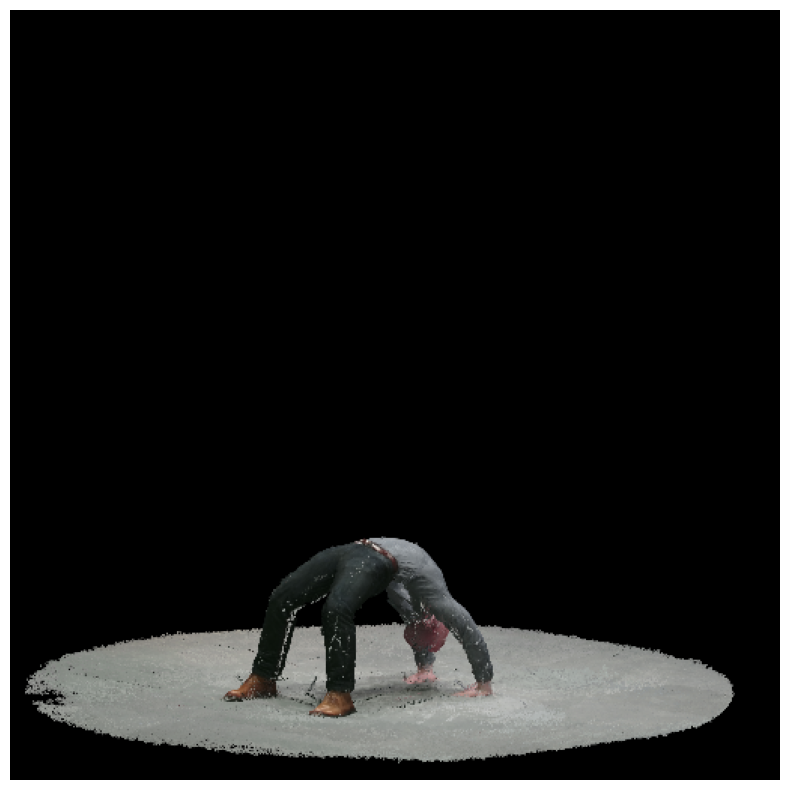

In [14]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");